In [26]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes (with the TensorFlow backend).
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave,imshow
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.applications.resnet50 import ResNet50
from keras import backend as K

In [29]:
# build the VGG16 network with ImageNet weights
model = ResNet50(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

Model loaded.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
_____________________________________________________________________________

In [44]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [46]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [48]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
layer_name = 'conv1'

In [49]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [50]:
kept_filters = []
for filter_index in range(0, 64):
    # we only scan through the first 64 filters,
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 40.6094
Current loss value: 42.016
Current loss value: 43.4226
Current loss value: 44.8292
Current loss value: 46.2357
Current loss value: 47.6423
Current loss value: 49.0489
Current loss value: 50.4554
Current loss value: 51.862
Current loss value: 53.2686
Current loss value: 54.6752
Current loss value: 56.0817
Current loss value: 57.4883
Current loss value: 58.8948
Current loss value: 60.3014
Current loss value: 61.708
Current loss value: 63.1146
Current loss value: 64.5211
Current loss value: 65.9277
Current loss value: 67.3343
Filter 0 processed in 1s
Processing filter 1
Current loss value: 17.5009
Current loss value: 21.4579
Current loss value: 25.415
Current loss value: 29.372
Current loss value: 33.3291
Current loss value: 37.2861
Current loss value: 41.2432
Current loss value: 45.2002
Current loss value: 49.1573
Current loss value: 53.1144
Current loss value: 57.0714
Current loss value: 61.0284
Current loss value: 64.9854
Current loss val

Current loss value: -71.5297
Filter 23 processed in 1s
Processing filter 24
Current loss value: -20.4459
Filter 24 processed in 1s
Processing filter 25
Current loss value: -3.61432
Filter 25 processed in 1s
Processing filter 26
Current loss value: -159.079
Filter 26 processed in 1s
Processing filter 27
Current loss value: 20.5506
Current loss value: 20.7234
Current loss value: 20.8961
Current loss value: 21.0689
Current loss value: 21.2417
Current loss value: 21.4145
Current loss value: 21.5873
Current loss value: 21.7601
Current loss value: 21.9329
Current loss value: 22.1057
Current loss value: 22.2785
Current loss value: 22.4513
Current loss value: 22.6241
Current loss value: 22.7969
Current loss value: 22.9697
Current loss value: 23.1425
Current loss value: 23.3153
Current loss value: 23.4881
Current loss value: 23.6609
Current loss value: 23.8337
Filter 27 processed in 1s
Processing filter 28
Current loss value: 18.286
Current loss value: 18.5721
Current loss value: 18.8581
Curren

Filter 56 processed in 1s
Processing filter 57
Current loss value: -0.679149
Filter 57 processed in 1s
Processing filter 58
Current loss value: 40.0
Current loss value: 41.0411
Current loss value: 42.0822
Current loss value: 43.1234
Current loss value: 44.1645
Current loss value: 45.2056
Current loss value: 46.2468
Current loss value: 47.2879
Current loss value: 48.3291
Current loss value: 49.3702
Current loss value: 50.4114
Current loss value: 51.4525
Current loss value: 52.4936
Current loss value: 53.5348
Current loss value: 54.5759
Current loss value: 55.617
Current loss value: 56.6582
Current loss value: 57.6993
Current loss value: 58.7405
Current loss value: 59.7816
Filter 58 processed in 1s
Processing filter 59
Current loss value: -3.96809
Filter 59 processed in 1s
Processing filter 60
Current loss value: -1.15365
Filter 60 processed in 1s
Processing filter 61
Current loss value: 48.1903
Current loss value: 49.4118
Current loss value: 50.6334
Current loss value: 51.855
Current lo

In [51]:
len(kept_filters)

28

In [52]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 5

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [53]:
len(kept_filters)

25

In [54]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [55]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

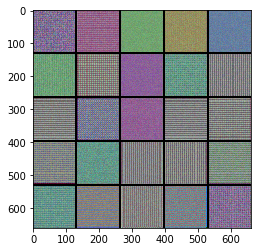

In [56]:
plt.imshow(stitched_filters)
plt.show()